# Lesson 5: State Estimation and Robust Control

This notebook extends the inverted pendulum lab with noisy measurements, state estimation, and robustness checks.

## Learning Objectives
- Add measurement noise and process noise to a linearized model.
- Implement a basic discrete-time Kalman filter.
- Compare controller performance with and without state estimation.
- Stress test the controller under parameter drift.

### Parameters (update as needed)
| Symbol | Meaning | Example |
| --- | --- | --- |
| m_c | Cart mass | 1.0 kg |
| m_p | Pendulum mass | 0.1 kg |
| L | Pendulum length | 0.5 m |
| g | Gravity | 9.81 m/s^2 |
| dt | Sample time | 0.01 s |

---
## Lesson Content


In [1]:
# Install required packages (Colab)
!pip -q install numpy scipy matplotlib


## Estimation is unavoidable
You do not see the true state.

Tasks:
- Hide true state and corrupt measurements with noise.
- Control with raw measurements and observe failure.
- Implement a simple observer, then a Kalman filter.
- Change noise statistics mid-run and compare robustness.

Deliverable: estimation error vs control performance.


## 1) Linearized Model and Feedback Gain
We use a simplified linearized model around the upright position for small angles. The state is:
- x = [theta, theta_dot]


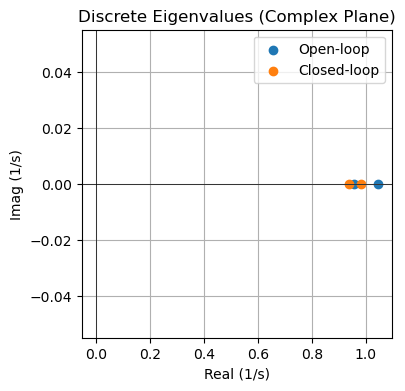

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m_c = 1.0
m_p = 0.1
L = 0.5
g = 9.81

dt = 0.01

# Linearized inverted pendulum (simplified)
A = np.array([[0.0, 1.0],
              [g / L, 0.0]])
B = np.array([[0.0],
              [1.0 / (m_c * L)]])

# Discrete-time approximation (Euler)
A_d = np.eye(2) + A * dt
B_d = B * dt

# Simple state feedback gain (tuned for stability)
K = np.array([[15.0, 4.0]])

# Eigenvalues for open-loop and closed-loop discrete system
open_eigs = np.linalg.eigvals(A_d)
closed_eigs = np.linalg.eigvals(A_d - B_d @ K)

plt.figure(figsize=(4, 4))
plt.scatter(np.real(open_eigs), np.imag(open_eigs), label='Open-loop')
plt.scatter(np.real(closed_eigs), np.imag(closed_eigs), label='Closed-loop')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('Discrete Eigenvalues (Complex Plane)')
plt.xlabel('Real (1/s)')
plt.ylabel('Imag (1/s)')
plt.legend()
plt.grid(True)
plt.show()


**Expected output:**
- Closed-loop eigenvalues should move closer to the origin compared to open-loop, indicating improved stability.


## 2) Noisy Measurements and Kalman Filter
We measure only the angle (theta) with noise. The Kalman filter estimates both theta and theta_dot.


/tmp/ipykernel_3376758/1767097610.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = -float(K @ x_est[k - 1])
/tmp/ipykernel_3376758/1767097610.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_naive = -float(K @ np.array([y, 0.0]))


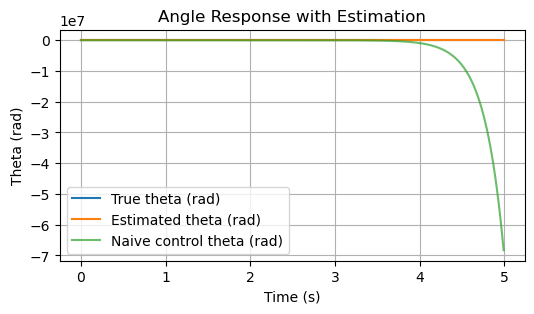

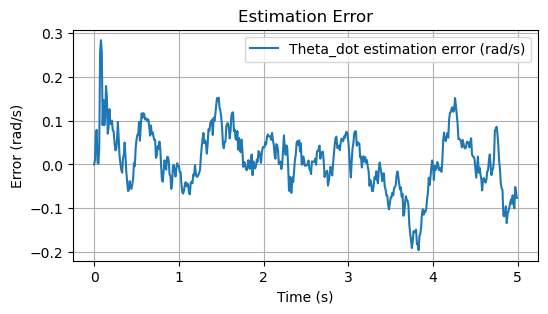

In [3]:
# Simulation settings
steps = 500
np.random.seed(0)

# Noise settings
Q = np.diag([1e-6, 1e-4])  # process noise covariance
R = np.array([[1e-3]])     # measurement noise covariance

C = np.array([[1.0, 0.0]])

# Allocate storage
x_true = np.zeros((steps, 2))
x_est = np.zeros((steps, 2))
x_naive = np.zeros((steps, 2))

u_est = np.zeros(steps)

# Initial conditions
x_true[0] = np.array([0.1, 0.0])
x_est[0] = np.array([0.0, 0.0])
P = np.eye(2) * 0.1

# Naive controller: uses noisy theta and assumes theta_dot = 0
x_naive[0] = x_true[0].copy()

for k in range(1, steps):
    # True system with process noise
    w = np.random.multivariate_normal([0.0, 0.0], Q)
    u = -float(K @ x_est[k - 1])
    x_true[k] = (A_d @ x_true[k - 1]) + (B_d.flatten() * u) + w

    # Measurement
    v = np.random.normal(0.0, np.sqrt(R[0, 0]))
    y = (C @ x_true[k]).item() + v

    # Kalman predict
    x_pred = A_d @ x_est[k - 1] + B_d.flatten() * u
    P_pred = A_d @ P @ A_d.T + Q

    # Kalman update
    S = C @ P_pred @ C.T + R
    Kf = P_pred @ C.T @ np.linalg.inv(S)
    x_est[k] = x_pred + (Kf.flatten() * (y - (C @ x_pred).item()))
    P = (np.eye(2) - Kf @ C) @ P_pred

    # Naive controller (uses noisy measurement, no velocity estimate)
    u_naive = -float(K @ np.array([y, 0.0]))
    x_naive[k] = (A_d @ x_naive[k - 1]) + (B_d.flatten() * u_naive)

    u_est[k] = u

# Plot results
t = np.arange(steps) * dt

plt.figure(figsize=(6, 3))
plt.plot(t, x_true[:, 0], label='True theta (rad)')
plt.plot(t, x_est[:, 0], label='Estimated theta (rad)')
plt.plot(t, x_naive[:, 0], label='Naive control theta (rad)', alpha=0.7)
plt.title('Angle Response with Estimation')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(t, x_true[:, 1] - x_est[:, 1], label='Theta_dot estimation error (rad/s)')
plt.title('Estimation Error')
plt.xlabel('Time (s)')
plt.ylabel('Error (rad/s)')
plt.legend()
plt.grid(True)
plt.show()


## 3) Robustness Check (Parameter Drift)
We perturb the pendulum length and check how the controller performs.


/tmp/ipykernel_3376758/3714856229.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = -float(K @ x_drift[k - 1])


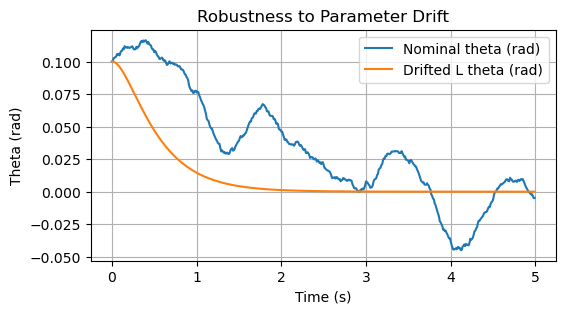

In [4]:
# Parameter drift: change length
L_drift = 0.6  # 20% longer
A_drift = np.array([[0.0, 1.0],
                    [g / L_drift, 0.0]])
A_drift = np.eye(2) + A_drift * dt

x_drift = np.zeros((steps, 2))
x_drift[0] = np.array([0.1, 0.0])

for k in range(1, steps):
    u = -float(K @ x_drift[k - 1])
    x_drift[k] = (A_drift @ x_drift[k - 1]) + (B_d.flatten() * u)

plt.figure(figsize=(6, 3))
plt.plot(t, x_true[:, 0], label='Nominal theta (rad)')
plt.plot(t, x_drift[:, 0], label='Drifted L theta (rad)')
plt.title('Robustness to Parameter Drift')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.legend()
plt.grid(True)
plt.show()


## Tasks
- Increase measurement noise and observe how the estimator performance changes.
- Adjust K and compare closed-loop stability and settling time.
- Try a different drift (e.g., L = 0.4 m) and report the effect.


## Observability in practice
Explain which measurements made the state estimator viable and how noise changed your control performance.


---
## Checkpoints
- Closed-loop eigenvalues are closer to the origin than open-loop.
- Estimated angle tracks the true angle more closely than the naive controller.
- Parameter drift degrades performance but does not destabilize the system for small changes.

## Common Pitfalls
- Forgetting to update discrete-time matrices after changing parameters.
- Using noise covariances that are orders of magnitude too large or too small.
- Confusing radians and degrees when interpreting plots.
